# Install Transformers Library

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Dataset

In [ ]:

df = pd.read_json('/content/drive/MyDrive/sarcasm-detection/Datasets/twitter/sarcasm_detection_shared_task_twitter_training.jsonl',lines=True)
df1 = pd.read_json('/content/drive/MyDrive/sarcasm-detection/Datasets/twitter/sarcasm_detection_shared_task_twitter_testing.jsonl',lines=True)

df['labels'] = df['label'].apply(lambda x: ['SARCASM', 'NOT_SARCASM'].index(x))
df1['labels'] = df1['label'].apply(lambda x: ['SARCASM', 'NOT_SARCASM'].index(x))
df1.tail()

,label,context,response,id,labels
1795,NOT_SARCASM,[I have been a business customer of MWeb @USER...,@USER @USER @USER is definitely the best out t...,twitter_1796,1
1796,SARCASM,[A woman refuses to have her temperature taken...,@USER @USER Ye let her out run wild and infect...,twitter_1797,0
1797,SARCASM,[The reason big government wants @USER out is ...,"@USER @USER @USER Thanks for that , I would ha...",twitter_1798,0
1798,NOT_SARCASM,[Happy #musicmonday and #thanks for #all your ...,@USER @USER @USER Yes also #found this on #new...,twitter_1799,1
1799,NOT_SARCASM,[Not long wrapped on the amazing #January22nd ...,@USER @USER @USER you still need to send the l...,twitter_1800,1


In [ ]:
df["tweets"]=df['response']
df1["tweets"]=df1['response']

In [ ]:
df.shape

(5000, 5)

In [ ]:
# check class distribution
df['labels'].value_counts(normalize = True)

1    0.5
0    0.5
Name: labels, dtype: float64

# Split train dataset into train, validation and test sets

In [ ]:

X_s = df['tweets'].values
y_s = df['labels'].values

Xt_s = df1['tweets'].head(1000).values
yt_s = df1['labels'].head(1000).values

train_text, temp_text, train_labels, temp_labels = X_s,Xt_s,y_s,yt_s

# we will use temp_text and temp_labels to create validation and test set
# val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
#                                                                 random_state=2018, 
#                                                                 test_size=0.5, 
#                                                                 stratify=temp_labels)
val_text, test_text, val_labels, test_labels=temp_text, temp_text, temp_labels, temp_labels

# X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2, random_state=42)


In [ ]:
# pip install -U sentence-transformers

# Import BERT Model and BERT Tokenizer

https://huggingface.co/transformers/pretrained_models.html

In [ ]:
# import BERT-base pretrained model
# bert = AutoModel.from_pretrained('bert-base-uncased')

# # Load the BERT tokenizer
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
bert = AutoModel.from_pretrained('bert-large-cased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-large-cased')

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]
# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 1142, 1110, 170, 1129, 3740, 2235, 17463, 2916, 102, 0], [101, 1195, 1209, 2503, 118, 9253, 170, 1129, 3740, 2235, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

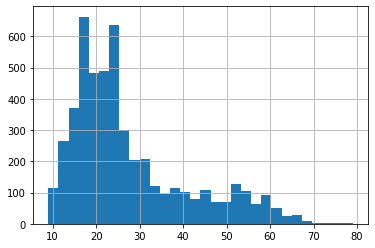

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 100

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = True
# print(bert)

#Define Model Layers

In [ ]:
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,dropout):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
  
import torch
import torch.nn as nn
import torch.nn.functional as F


class NetVLAD(nn.Module):
    """NetVLAD layer implementation"""

    def __init__(self, num_clusters=64, dim=128, alpha=100.0,
                 normalize_input=True):
        """
        Args:
            num_clusters : int
                The number of clusters
            dim : int
                Dimension of descriptors
            alpha : float
                Parameter of initialization. Larger value is harder assignment.
            normalize_input : bool
                If true, descriptor-wise L2 normalization is applied to input.
        """
        super(NetVLAD, self).__init__()
        self.num_clusters = num_clusters
        self.dim = dim
        self.alpha = alpha
        self.normalize_input = normalize_input
        self.conv = nn.Conv2d(dim, num_clusters, kernel_size=(1, 1), bias=True)
        self.centroids = nn.Parameter(torch.rand(num_clusters, dim))
        self._init_params()

    def _init_params(self):
        self.conv.weight = nn.Parameter(
            (2.0 * self.alpha * self.centroids).unsqueeze(-1).unsqueeze(-1)
        )
        self.conv.bias = nn.Parameter(
            - self.alpha * self.centroids.norm(dim=1)
        )

    def forward(self, x):
        N, C = x.shape[:2]

        if self.normalize_input:
            x = F.normalize(x, p=2, dim=1)  # across descriptor dim

        # soft-assignment
        soft_assign = self.conv(x).view(N, self.num_clusters, -1)
        soft_assign = F.softmax(soft_assign, dim=1)

        x_flatten = x.view(N, C, -1)
        
        # calculate residuals to each clusters
        residual = x_flatten.expand(self.num_clusters, -1, -1, -1).permute(1, 0, 2, 3) - \
            self.centroids.expand(x_flatten.size(-1), -1, -1).permute(1, 2, 0).unsqueeze(0)
        residual *= soft_assign.unsqueeze(2)
        vlad = residual.sum(dim=-1)

        vlad = F.normalize(vlad, p=2, dim=2)  # intra-normalization
        vlad = vlad.view(x.size(0), -1)  # flatten
        vlad = F.normalize(vlad, p=2, dim=1)  # L2 normalize

        return vlad

In [ ]:
class NeXtVLAD(object):
    """
  This is a paddlepaddle implementation of the NeXtVLAD model. For more
  information, please refer to the paper,
   https://static.googleusercontent.com/media/research.google.com/zh-CN//youtube8m/workshop2018/p_c03.pdf
  """

    def __init__(self,
                 feature_size,
                 cluster_size,
                 is_training=True,
                 expansion=2,
                 groups=None,
                 inputname='video'):
        self.feature_size = feature_size
        self.cluster_size = cluster_size
        self.is_training = is_training
        self.expansion = expansion
        self.groups = groups
        self.name = inputname + '_'

    def forward(self, input):
        input = fluid.layers.fc(
            input=input,
            size=self.expansion * self.feature_size,
            act=None,
            name=self.name + 'fc_expansion',
            param_attr=fluid.ParamAttr(
                name=self.name + 'fc_expansion_w',
                initializer=fluid.initializer.MSRA(uniform=False)),
            bias_attr=fluid.ParamAttr(
                name=self.name + 'fc_expansion_b',
                initializer=fluid.initializer.Constant(value=0.)))

        # attention factor of per group
        attention = fluid.layers.fc(
            input=input,
            size=self.groups,
            act='sigmoid',
            name=self.name + 'fc_group_attention',
            param_attr=fluid.ParamAttr(
                name=self.name + 'fc_group_attention_w',
                initializer=fluid.initializer.MSRA(uniform=False)),
            bias_attr=fluid.ParamAttr(
                name=self.name + 'fc_group_attention_b',
                initializer=fluid.initializer.Constant(value=0.)))

        # calculate activation factor of per group per cluster
        feature_size = self.feature_size * self.expansion // self.groups
        cluster_weights = fluid.layers.create_parameter(
            shape=[
                self.expansion * self.feature_size,
                self.groups * self.cluster_size
            ],
            dtype=input.dtype,
            attr=fluid.ParamAttr(name=self.name + 'cluster_weights'),
            default_initializer=fluid.initializer.MSRA(uniform=False))

        activation = fluid.layers.matmul(input, cluster_weights)
        activation = fluid.layers.batch_norm(
            activation, is_test=(not self.is_training))

        # reshape of activation
        activation = fluid.layers.reshape(activation,
                                          [-1, self.groups, self.cluster_size])
        # softmax on per cluster
        activation = fluid.layers.softmax(activation)
        activation = fluid.layers.elementwise_mul(activation, attention, axis=0)
        a_sum = fluid.layers.sequence_pool(activation, 'sum')
        a_sum = fluid.layers.reduce_sum(a_sum, dim=1)

        # create cluster_weights2
        cluster_weights2 = fluid.layers.create_parameter(
            shape=[self.cluster_size, feature_size],
            dtype=input.dtype,
            attr=fluid.ParamAttr(name=self.name + 'cluster_weights2'),
            default_initializer=fluid.initializer.MSRA(uniform=False))

        # expand a_sum dimension from [-1, self.cluster_size] to be [-1, self.cluster_size, feature_size]
        a_sum = fluid.layers.reshape(a_sum, [-1, self.cluster_size, 1])
        a_sum = fluid.layers.expand(a_sum, [1, 1, feature_size])

        # element wise multiply a_sum and cluster_weights2
        a = fluid.layers.elementwise_mul(
            a_sum, cluster_weights2,
            axis=1)  # output shape [-1, self.cluster_size, feature_size]

        # transpose activation from [-1, self.groups, self.cluster_size] to [-1, self.cluster_size, self.groups]
        activation2 = fluid.layers.transpose(activation, perm=[0, 2, 1])
        # transpose op will clear the lod infomation, so it should be reset
        activation = fluid.layers.lod_reset(activation2, activation)

        # reshape input from [-1, self.expansion * self.feature_size] to [-1, self.groups, feature_size]
        reshaped_input = fluid.layers.reshape(input,
                                              [-1, self.groups, feature_size])
        # mat multiply activation and reshaped_input
        vlad = fluid.layers.matmul(
            activation,
            reshaped_input)  # output shape [-1, self.cluster_size, feature_size]
        vlad = fluid.layers.sequence_pool(vlad, 'sum')
        vlad = fluid.layers.elementwise_sub(vlad, a)

        # l2_normalization
        vlad = fluid.layers.transpose(vlad, [0, 2, 1])
        vlad = fluid.layers.l2_normalize(vlad, axis=1)

        # reshape and batch norm
        vlad = fluid.layers.reshape(vlad,
                                    [-1, self.cluster_size * feature_size])
        vlad = fluid.layers.batch_norm(vlad, is_test=(not self.is_training))

        return vlad

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      # self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      # self.relu =  nn.ReLU()

      # dense layer 1
      # self.fc1 = nn.Linear(768,512)
      # self.fc1 = BiRNN(input_size=32768, hidden_size=1024, num_layers=2,num_classes=512,dropout=0.25).to(device) 

      # self.fc1 = nn.LSTM(input_size=768, hidden_size=1024, num_layers=2, batch_first=True,dropout=0.25, bidirectional=True).to(device)
      self.fc1 = BiRNN(input_size=1024, hidden_size=1024, num_layers=2,num_classes=512,dropout=0.25).to(device)
      # self.fc1_2 = NetVLAD(dim=512,num_clusters= 32, normalize_input=False).to(device)   
      
      
      
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,64)
      self.fc2_3 = nn.Linear(64,2)





      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id,mask, return_dict=False)
      # print("dfghjjhfchgbhlvmb jfbvfddvfgbhnjhgvcvtynubtrvcebnuexcvbnbtvrcedcvbnjbnjn ",cls_hs.shape)
      # !nvidia-smi
      
      # x = self.fc1(cls_hs)

      # x = self.relu(x)

      # x = self.dropout(x)
      x = cls_hs.view(-1,1,1024)
      # print("dfghjjhfchgbhlvmb jfbvfddvfgbhnjhgvcvtynubtrvcebnuex ",x.shape)

      x = self.fc1(x)
      # print("dfghjjhfchgbhlvmb jfbvfddvfgbhnjhgvcvtynubtrvcebnuex ",x.shape)
      

      # x = x.view(-1,512,1,1)
      # print("dfghjjhfchgbhlvmb jfbvfddvfgbhnjhgvcvtynubtrvcebnuexcvbnbtvrcedcvbnjbnjn ",x.shape)

      # x = self.fc1_2(x)
      # print("dfghjjhfchgbhlvmb jfbvfddvfgbhnjhgvcvtynubtrvcebnuexcvbnbtvrcedcvbnjbnjn ",x.shape)
      
      # output layer
      x = self.fc2(x)
      x=self.fc2_3(x)
      # print("dfghjjhfchgbhlvmb jfbvfddvfgbhnjhgvcvtynubtrvcebnuexcvbnbtvrcedcvbnjbnjn ",x.shape)
      
      # apply softmax activation
      x = self.softmax(x)
      # print("dfghjjhfchgbhlvmb jfbvfddvfgbhnjhgvcvtynubtrvcebnuexcvbnbtvrcedcvbnjbnjn ",x.shape)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
import torch
torch.cuda.empty_cache()
import gc
# del variables
gc.collect()
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

#Define Cyclic Learning Rate

In [ ]:
# optimizer from hugging face transformers
import math

# # number of training epochs
epochs = 10


from transformers import AdamW

# define the optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=2e-4)
optimizer = AdamW(model.parameters(), lr = 2e-6)

# scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=.999,last_epoch = 1,verbose = True)	
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=2e-4, step_size_up=200, step_size_down=None, mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=True, base_momentum=0.725, max_momentum=0.825, last_epoch=-1, verbose=True)


# Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1. 1.]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
# epochs = 10

# Fine-Tune BERT

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  # Make lists to capture the logs

  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # Update LR
    # scheduler.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
import torch
torch.cuda.empty_cache()
import gc
from torch.autograd import Variable
del Variable
gc.collect()

200

# Start Model Training

In [ ]:
import torch
torch.cuda.empty_cache()
import gc
# del variables
gc.collect()


# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
epochs=1
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss,_ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)


    import torch
    torch.cuda.empty_cache()
    import gc
    # del variables
    gc.collect()
    !nvidia-smi

    # with torch.no_grad():
    #   preds = model(test_seq.to(device), test_mask.to(device))
    #   preds = preds.detach().cpu().numpy()
    # # model's performance
    # preds = np.argmax(preds, axis = 1)
    # print(classification_report(test_y, preds))
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 1
  Batch    50  of    157.
  Batch   100  of    157.
  Batch   150  of    157.

Evaluating...
Wed Jun 16 20:01:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    37W /  70W |   7386MiB / 15109MiB |     21%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-----

In [ ]:
!nvidia-smi

Wed Jun 16 20:01:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    37W /  70W |   7386MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
!nvidia-smi

Wed Jun 16 20:01:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    42W /  70W |   8524MiB / 15109MiB |     19%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get Predictions for Test Data

In [ ]:
# get predictions for test data
import torch
torch.cuda.empty_cache()
import gc
from torch.autograd import Variable
del Variable
gc.collect()

with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.69      0.74      0.71       491
           1       0.73      0.68      0.71       509

    accuracy                           0.71      1000
   macro avg       0.71      0.71      0.71      1000
weighted avg       0.71      0.71      0.71      1000



In [ ]:
!nvidia-smi

Wed Jun 16 20:01:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0    40W /  70W |  14094MiB / 15109MiB |     99%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# confusion matrix
# pd.crosstab(test_y, preds)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

print(accuracy_score(test_y, preds))

0.71


In [ ]:
!nvidia-smi

Wed Jun 16 20:01:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0    43W /  70W |  14094MiB / 15109MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvidia-smi

Wed Jun 16 20:01:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0    43W /  70W |  14094MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------